# Code

In [1]:
%pip install PyGithub python-dotenv pandas tqdm matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime


In [3]:
ORGANIZATIONS = [
    # "aws-samples", # 6.3k
    # "Azure-Samples", # 2.6k
    # "googlesamples", # 71
    # "spring-guides", # 74
    # "googlearchive", # 973
    "spring-cloud-samples", # 29
]
EXCLUDED_REPOS = [
    "googlearchive/digits-migration-helper-android",
    "googlearchive/play-apk-expansion",
    "googlearchive/tiger",
    "googlearchive/two-token-sw",
    "googlearchive/Abelana-Android",
    "googlearchive/solutions-mobile-backend-starter-java"
]

In [4]:
load_dotenv()
github_client = Github(getenv('GITHUB_TOKEN'), per_page=100)

In [5]:
def fetch_organization_repositories(organization_name, language=None):
    organization = github_client.get_organization(organization_name)
    repositories = organization.get_repos("all")
    total_repositories = repositories.totalCount
    repo_data = []

    def process_repo(repo):
        if repo.full_name in EXCLUDED_REPOS:
            return None

        if organization_name == "googlearchive" and not is_valid_googlearchive_repo(repo):
            return None
        elif organization_name == "SAP-samples" and not is_valid_sap_sample_repo(repo):
            return None

        repo_languages = repo.get_languages()
        total_lines = sum(repo_languages.values())
        language_percentages = {lang: f'{(lines/total_lines):.2%}' for lang, lines in repo_languages.items()}

        issues_count = repo.get_issues(state="all").totalCount
        closed_issues_count = repo.get_issues(state="closed").totalCount
        pulls = repo.get_pulls(state="all")
        total_pulls_count = pulls.totalCount
        open_pulls_count = repo.get_pulls(state="open").totalCount
        closed_pulls_count = repo.get_pulls(state="closed").totalCount
        merged_pulls_count = sum(1 for pr in pulls if pr.merged_at is not None)
        commits_count = repo.get_commits().totalCount
        first_commit_date = repo.get_commits().reversed[0].commit.author.date
        last_commit_date = repo.get_commits()[0].commit.author.date
        branches_count = repo.get_branches().totalCount
        topics = repo.get_topics()
        contributors_count = repo.get_contributors().totalCount

        return {
            "full_name": repo.full_name,
            "name": repo.name,
            "owner": repo.owner.login,
            "html_url": repo.html_url,
            "description": repo.description,
            "language": repo.language,
            "created_at": repo.created_at,
            "updated_at": repo.updated_at,
            "pushed_at": repo.pushed_at,
            "size": repo.size,
            "stargazers_count": repo.stargazers_count,
            "watchers_count": repo.watchers_count,
            "forks_count": repo.forks_count,
            "open_issues_count": repo.open_issues_count,
            "subscribers_count": repo.subscribers_count,
            "network_count": repo.network_count,
            "archived": repo.archived,
            "total_lines": total_lines,
            "langs_percentage": language_percentages,
            "issues_count": issues_count,
            "closed_issues_count": closed_issues_count,
            "closed_pulls_count": closed_pulls_count,
            "open_pulls_count": open_pulls_count,
            "total_pulls_count": total_pulls_count,
            "merged_pulls_count": merged_pulls_count,
            "commits_count": commits_count,
            "first_commit_date": first_commit_date,
            "last_commit_date": last_commit_date,
            "branches_count": branches_count,
            "topics": topics,
            "contributors_count": contributors_count,
        }

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_repo, repo) for repo in repositories]
        for future in tqdm(as_completed(futures), desc=organization_name, unit=" repos", total=total_repositories, ncols=100):
            result = future.result()
            if result:
                repo_data.append(result)
                
    return pd.DataFrame(repo_data)

def is_valid_googlearchive_repo(repo):
    if not repo.description:
        return False
    keywords = ["example", "sample", "migrated"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)

def is_valid_sap_sample_repo(repo):
    if not repo.description:
        return False
    keywords = ["cloud"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)


In [6]:
def generate_metrics_csv():
    all_repos_data = []
    
    def fetch_data_for_organization(organization):
        print(f'Retrieving repos from {organization}...')
        organization_repos_data = fetch_organization_repositories(organization)
        if not organization_repos_data.empty:
            return organization_repos_data
        else:
            return pd.DataFrame()

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_data_for_organization, org) for org in ORGANIZATIONS]
        for future in tqdm(as_completed(futures), desc="Processing organizations", unit=" orgs"):
            org_data = future.result()
            if not org_data.empty:
                all_repos_data.append(org_data)

    all_repos_data_df = pd.concat(all_repos_data, ignore_index=True) if all_repos_data else pd.DataFrame()
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_path = f"results/codesamples_{timestamp}.csv"
    all_repos_data_df.to_csv(file_path, index=False)

    return all_repos_data_df

In [7]:
def calculate_language_usage(dataframe):
    language_usage = {}

    for repo in dataframe.itertuples():
        repo_languages = repo.langs_percentage
        total_lines = repo.total_lines

        for language, percentage in repo_languages.items():
            lines = total_lines * (float(percentage.strip('%')) / 100)
            language_usage[language] = language_usage.get(language, 0) + lines

    total_lines_of_code = sum(language_usage.values())

    formatted_languages = sorted(
        [(language, f'{(lines / total_lines_of_code):.2%}', int(lines)) for language, lines in language_usage.items()],
        key=lambda item: float(item[1].strip('%')),
        reverse=True
    )

    file_path = f"results/languages_usage.csv"
    dataframeLanguages = pd.DataFrame(formatted_languages, columns=["Language", "Usage Percentage", "Lines"])
    dataframeLanguages.to_csv(file_path, index=False)
    return dataframeLanguages


In [8]:
def generate_statistics(dataframe):
    numeric_metrics = dataframe[METRICS].select_dtypes(include='number')
    
    statistics = numeric_metrics.describe().transpose()
    
    statistics['median'] = numeric_metrics.median()
    statistics['mode'] = numeric_metrics.mode().iloc[0]
    
    file_path = f"results/statistics.csv"
    statistics.to_csv(file_path)
    
    return statistics

In [9]:
def plot_metrics_distribution(metricts):
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metricts):
        plt.subplot(3, 3, i + 1)
        sns.histplot(dataframe[metric], kde=True, bins=30, color='blue', alpha=0.6)
        plt.axvline(dataframe[metric].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(dataframe[metric].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.savefig('results/distribution_metrics.png')
    plt.show()

In [10]:
def plot_metrics_boxplot(metricts):
    numeric_metrics = dataframe[metricts].select_dtypes(include='number')
    
    plt.figure(figsize=(16, 12))
    for i, metric in enumerate(numeric_metrics.columns):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(x=numeric_metrics[metric], color='lightblue')
        plt.title(f'Boxplot of {metric}')
        plt.xlabel(metric)
    
    plt.tight_layout()
    plt.savefig('results/boxplot_metrics.png')
    plt.show()

In [11]:
def plot_metrics_statistics(metricts):
    desc_stats = dataframe[metricts].describe().T[['mean', '50%', 'std']]
    desc_stats.columns = ['Mean', 'Median', 'Standard Deviation']
    desc_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('Descriptive Statistics of Repository Metrics')
    plt.ylabel('Values')
    plt.xticks(rotation=0)
    plt.savefig('results/metrics_statistics.png')
    plt.show()

# Results

In [12]:
METRICS = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines'
]

In [13]:
dataframe = generate_metrics_csv()
dataframe

Retrieving repos from spring-cloud-samples...


spring-cloud-samples: 100%|█████████████████████████████████████| 29/29 [00:23<00:00,  1.26 repos/s]
Processing organizations: 1 orgs [00:25, 25.13s/ orgs]


,full_name,name,owner,html_url,description,language,created_at,updated_at,pushed_at,size,...,closed_pulls_count,open_pulls_count,total_pulls_count,merged_pulls_count,commits_count,first_commit_date,last_commit_date,branches_count,topics,contributors_count
0,spring-cloud-samples/spring-cloud-contract-nod...,spring-cloud-contract-nodejs-contracts-git,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,Contracts repsitory for the https://github.com...,None,2018-03-30 12:37:35+00:00,2021-04-26 15:09:11+00:00,2021-04-26 15:09:09+00:00,0,...,0,0,0,0,1,2018-03-29 12:20:09+00:00,2018-03-29 12:20:09+00:00,1,[],1
1,spring-cloud-samples/brewery-config,brewery-config,spring-cloud-samples,https://github.com/spring-cloud-samples/brewer...,Configuration for the Brewery,None,2016-02-23 13:32:01+00:00,2021-04-26 15:03:01+00:00,2021-04-26 15:02:59+00:00,0,...,1,0,1,0,1,2016-02-23 13:33:32+00:00,2016-02-23 13:33:32+00:00,1,[],1
2,spring-cloud-samples/svn-config-server,svn-config-server,spring-cloud-samples,https://github.com/spring-cloud-samples/svn-co...,Sample Config Server and Config Client. The C...,Java,2015-03-17 17:01:12+00:00,2023-05-16 08:38:56+00:00,2023-10-30 13:59:51+00:00,6,...,1,1,2,0,5,2015-03-16 22:00:18+00:00,2016-01-20 00:47:07+00:00,2,[],2
3,spring-cloud-samples/spring-cloud-config-vault,spring-cloud-config-vault,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,Sample application demonstrating how to use Ha...,Java,2018-10-29 23:17:57+00:00,2024-02-18 22:56:13+00:00,2021-04-26 15:09:18+00:00,66,...,1,1,2,1,4,2018-10-29 23:19:12+00:00,2019-03-20 13:51:14+00:00,1,[],2
4,spring-cloud-samples/feign-eureka,feign-eureka,spring-cloud-samples,https://github.com/spring-cloud-samples/feign-...,Example of using feign with eureka,Java,2015-01-07 19:43:47+00:00,2024-06-17 16:52:09+00:00,2024-06-17 17:23:13+00:00,120,...,6,3,9,4,20,2015-01-07 19:43:47+00:00,2024-06-17 16:52:01+00:00,6,[],5
5,spring-cloud-samples/configserver,configserver,spring-cloud-samples,https://github.com/spring-cloud-samples/config...,None,Java,2014-07-20 16:20:55+00:00,2024-06-18 14:33:03+00:00,2022-03-09 20:45:29+00:00,113,...,5,1,6,4,81,2014-07-14 11:59:59+00:00,2021-06-15 12:43:02+00:00,12,[],6
6,spring-cloud-samples/bookstore-service-broker,bookstore-service-broker,spring-cloud-samples,https://github.com/spring-cloud-samples/bookst...,Sample application for Spring Cloud Open Servi...,Java,2017-12-27 22:38:55+00:00,2023-10-31 05:22:23+00:00,2021-11-06 23:46:44+00:00,401,...,10,3,13,9,82,2017-12-27 22:38:50+00:00,2021-03-05 16:48:38+00:00,4,"[cloudfoundry, kubernetes, open-service-broker...",4
7,spring-cloud-samples/spring-cloud-contract-nod...,spring-cloud-contract-nodejs-external-contracts,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,External contracts for the Spring Cloud Contra...,Java,2018-03-15 15:42:55+00:00,2021-04-26 15:04:54+00:00,2021-04-26 15:04:51+00:00,60,...,2,1,3,2,6,2018-03-15 13:45:47+00:00,2020-09-18 11:47:17+00:00,1,[],2
8,spring-cloud-samples/the-legacy-app,the-legacy-app,spring-cloud-samples,https://github.com/spring-cloud-samples/the-le...,[S1P 2017] the legacy app that calls the mainf...,Java,2018-10-26 09:33:57+00:00,2024-07-10 20:26:05+00:00,2024-07-10 20:26:01+00:00,314,...,24,0,24,20,75,2017-12-01 10:53:18+00:00,2024-07-10 20:26:00+00:00,9,[],5
9,spring-cloud-samples/spring-cloud-gateway-sample,spring-cloud-gateway-sample,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,Sample Spring Cloud Gateway Application,Java,2017-10-13 16:41:13+00:00,2024-07-27 06:24:56+00:00,2021-12-07 20:03:34+00:00,79,...,2,9,11,0,21,2017-10-13 16:42:29+00:00,2021-12-07 20:03:31+00:00,2,"[spring-cloud, spring-cloud-gateway, spring-bo...",1


In [14]:
dataframeLanguages = calculate_language_usage(dataframe)
dataframeLanguages

,Language,Usage Percentage,Lines
0,Java,71.17%,1151058
1,Shell,11.07%,178949
2,Groovy,6.09%,98445
3,Kotlin,4.91%,79406
4,JavaScript,3.49%,56519
5,HTML,2.74%,44298
6,Less,0.42%,6720
7,Dockerfile,0.07%,1063
8,Python,0.04%,646
9,Lua,0.01%,120


In [15]:
dataframe_statistics = generate_statistics(dataframe)
dataframe_statistics

,count,mean,std,min,25%,50%,75%,max,median,mode
size,29.0,2952.206897,8238.879823,0.0,64.0,153.0,616.0,37077.0,153.0,0.0
stargazers_count,29.0,112.827586,161.337727,0.0,1.0,22.0,209.0,498.0,22.0,0.0
watchers_count,29.0,112.827586,161.337727,0.0,1.0,22.0,209.0,498.0,22.0,0.0
forks_count,29.0,112.275862,195.974652,1.0,5.0,19.0,109.0,891.0,19.0,5.0
open_issues_count,29.0,5.413793,6.997537,0.0,1.0,2.0,8.0,27.0,2.0,0.0
subscribers_count,29.0,11.482759,11.014992,2.0,4.0,6.0,15.0,45.0,6.0,3.0
network_count,29.0,113.931034,195.424982,1.0,5.0,22.0,113.0,891.0,22.0,5.0
total_lines,29.0,55770.172414,135827.116053,0.0,1999.0,7597.0,59265.0,726505.0,7597.0,0.0


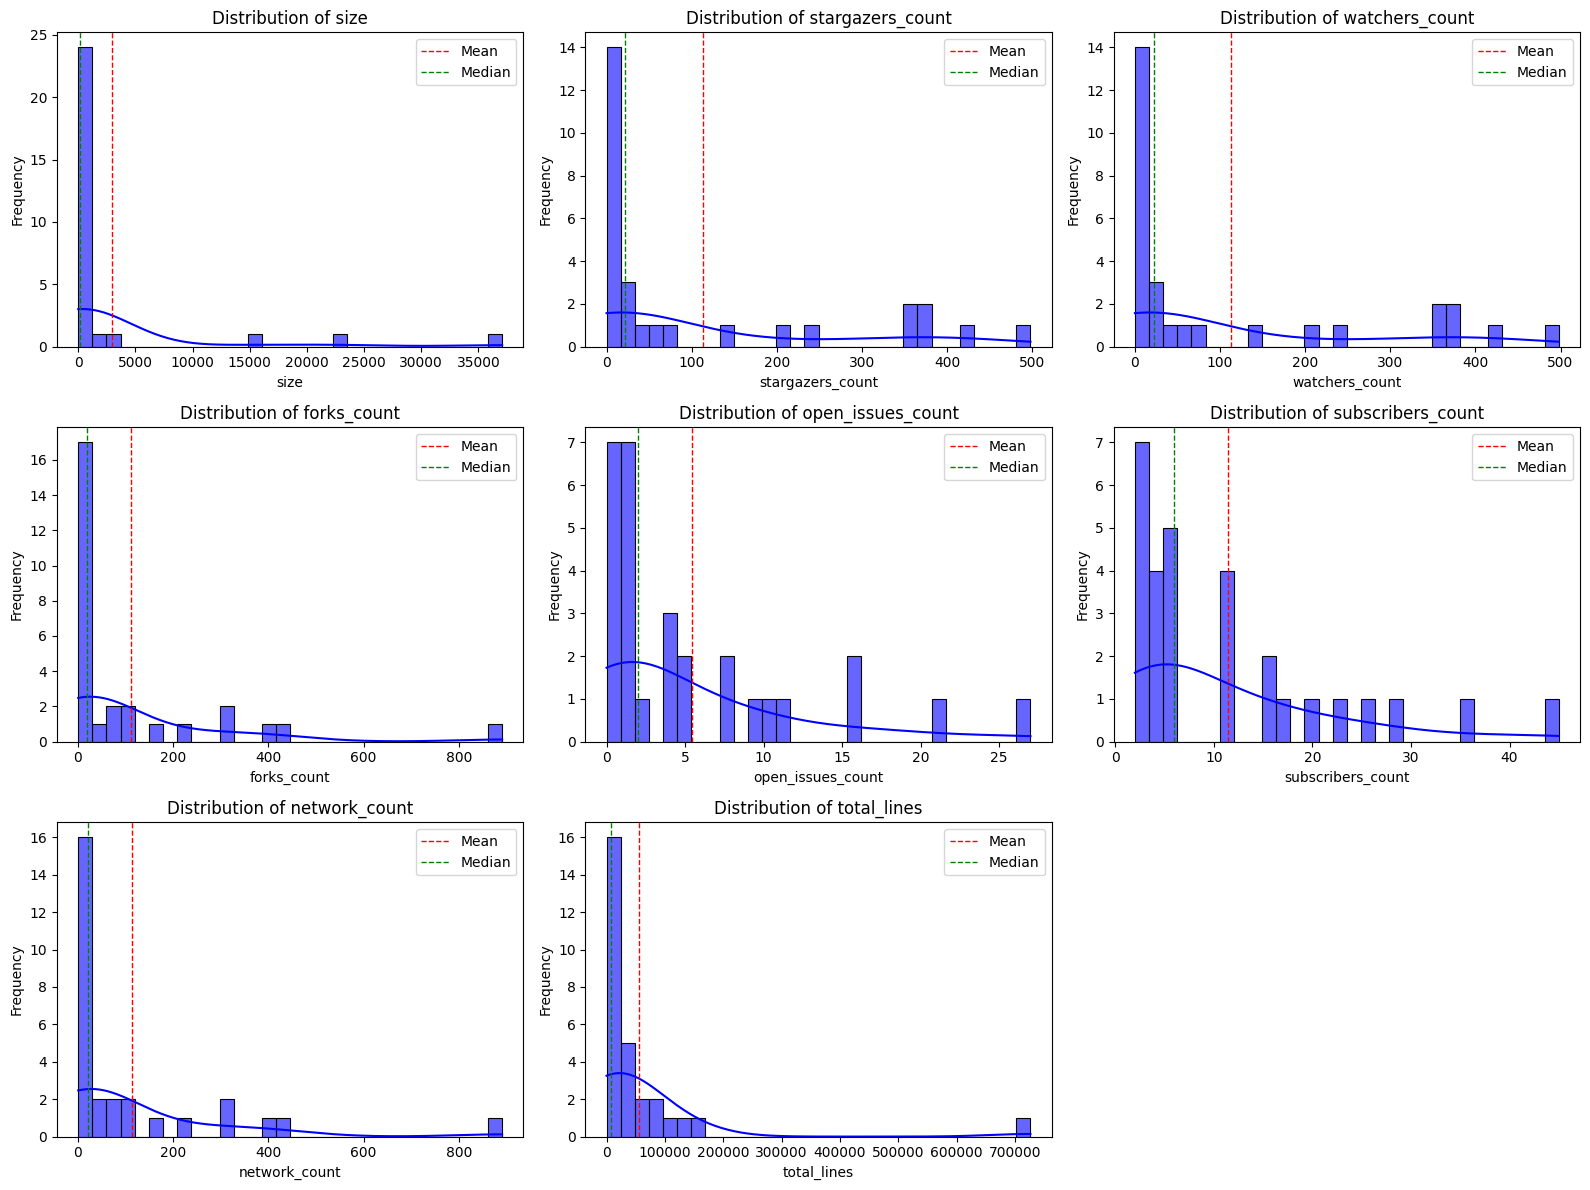

In [16]:
metricts = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines'
]
plot_metrics_distribution(metricts)

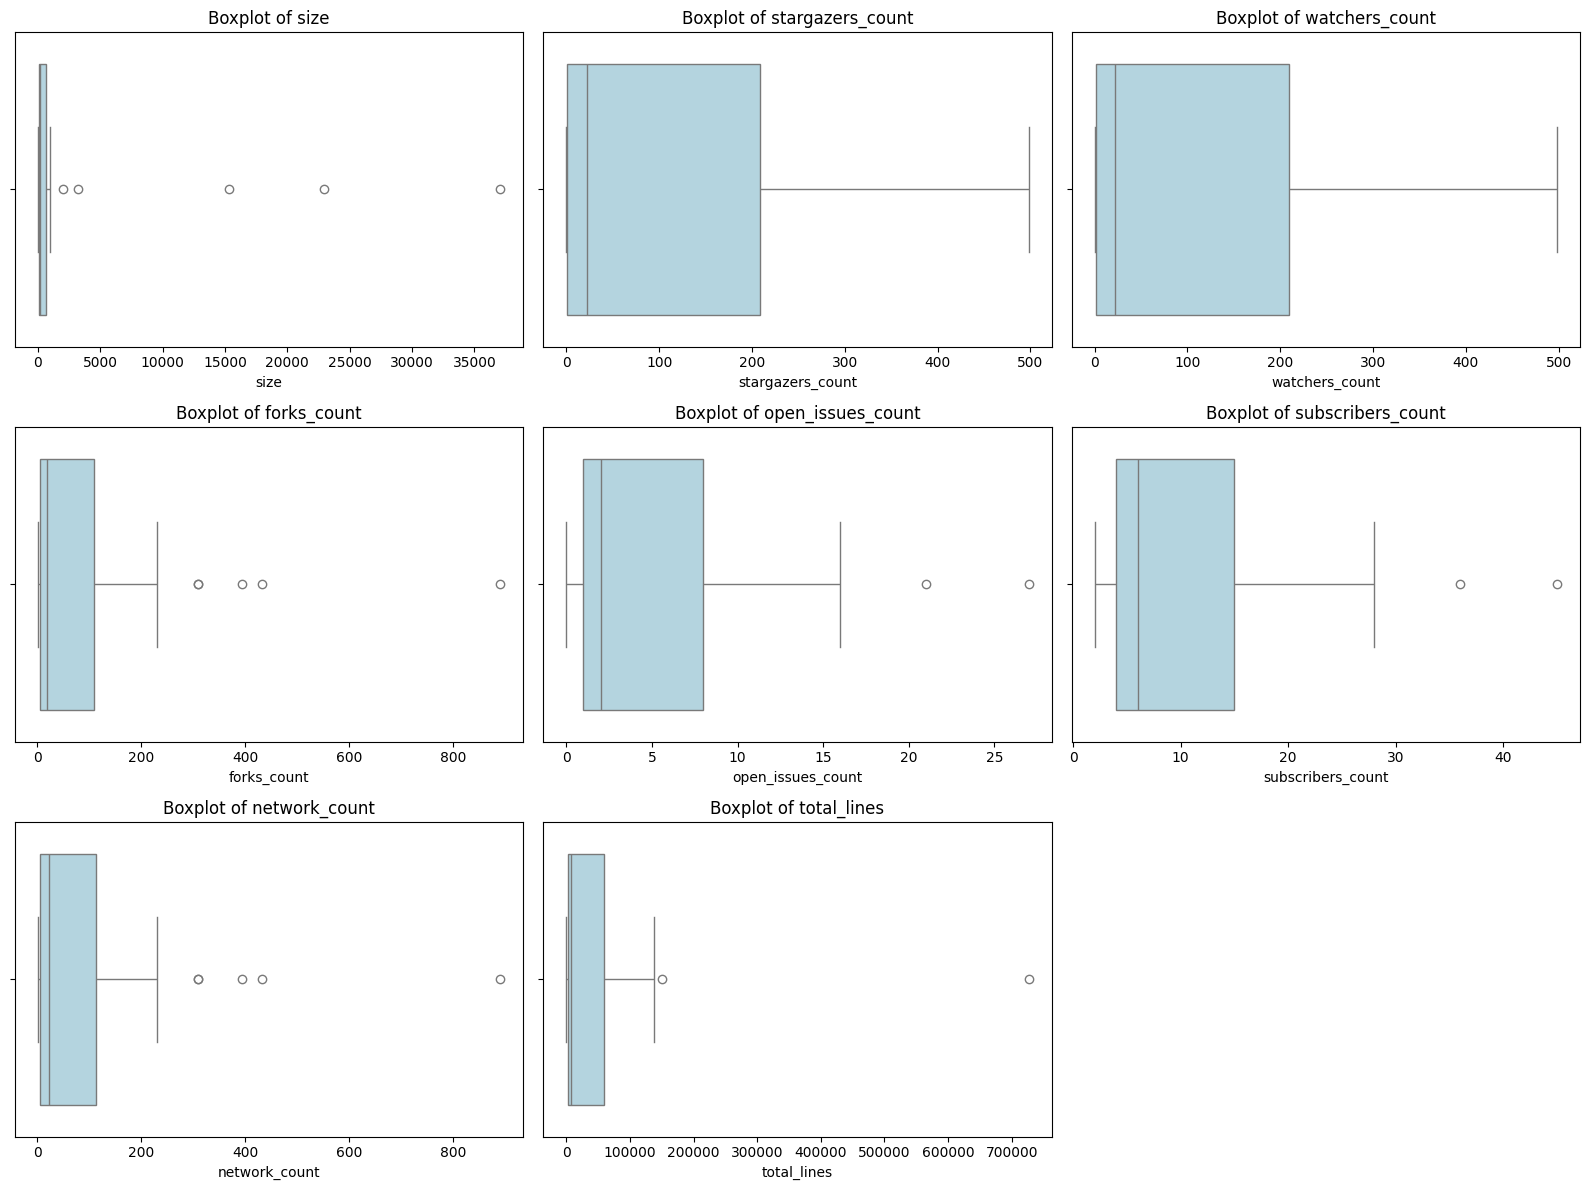

In [17]:
metricts = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines'
]
plot_metrics_boxplot(metricts)

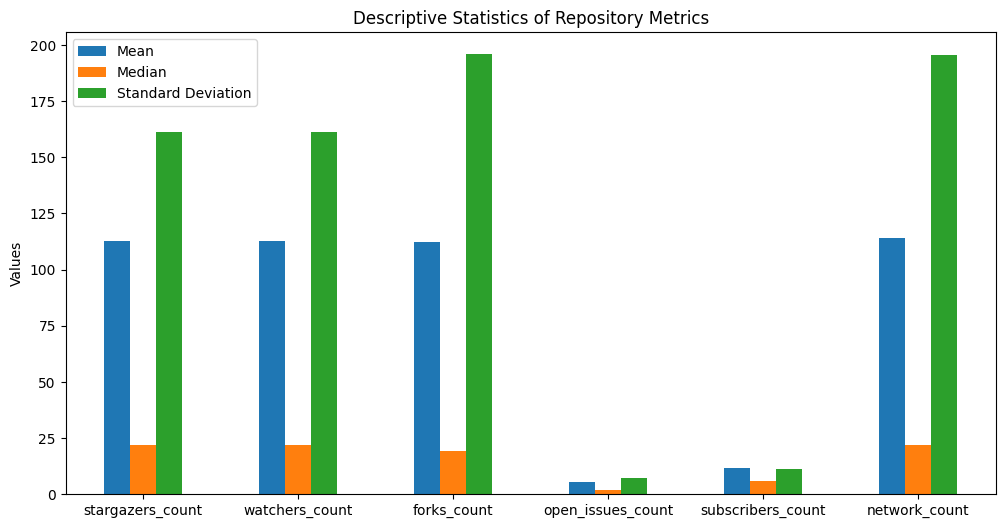

In [18]:
metricts = [
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
]
plot_metrics_statistics(metricts)